## Imports

In [46]:
import cv2
import numpy as np
import rawpy
import os
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load images (just to see them lol)

In [47]:
def load_image(image_path):
    ext = os.path.splitext(image_path)[-1].lower()
    if ext in ['.jpg', '.jpeg', '.png']:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif ext in ['.dng', '.nef', '.cr2']:  # RAW formats
        with rawpy.imread(image_path) as raw:
            image = raw.postprocess()
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        raise ValueError("Unsupported file format")
    return image

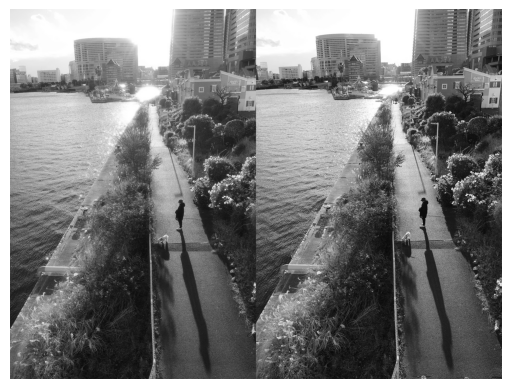

In [48]:
DIR = "ricoh-dataset/"
image_diff = load_image(f"{DIR}ricoh_images_diff.jpg")
image_org = load_image(f"{DIR}ricoh_images_org.jpg")

image_diff_2 = load_image(f"{DIR}ricoh_images_diff_2.jpg")
image_org_2 = load_image(f"{DIR}ricoh_images_org_2.jpg")

image_diff_3 = load_image(f"{DIR}ricoh_images_diff_3.jpeg")
image_org_3 = load_image(f"{DIR}ricoh_images_org_3.jpeg")

# Display the image using matplotlib
plt.imshow(np.hstack([image_diff, image_org]))
plt.axis('off')  # Hide the axis
plt.show()

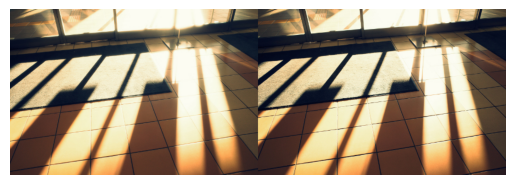

In [49]:
plt.imshow(np.hstack([image_diff_2, image_org_2]))
plt.axis('off')  # Hide the axis
plt.show()

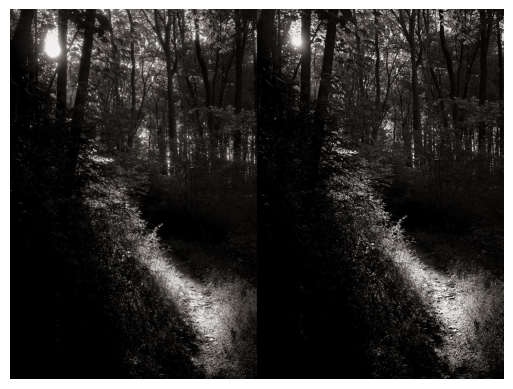

In [50]:
plt.imshow(np.hstack([image_diff_3, image_org_3]))
plt.axis('off')  # Hide the axis
plt.show()

## 2. Gaussian kernel

# Defining Gaussian Kernel Size Based on Pixel Intensity

In this notebook, we define a function that maps a pixel intensity (0–255) to a Gaussian kernel's standard deviation ($\sigma$). The kernel size is then computed as a function of $\sigma$. This adaptive mapping will allow us to emulate the diffusion filter's effect in highlight regions by applying a larger blur (i.e., a larger kernel) in brighter areas.

The Gaussian kernel is a matrix used to blur an image in a way that mimics the natural scattering of light. Its values are determined by the Gaussian (bell-curve) function:
$$\begin{align*}

G(x, y; \sigma) = \frac{1}{2\pi\sigma^2} \exp\left(-\frac{x^2 + y^2}{2\sigma^2}\right)

\end{align*}$$ 

- $\sigma$: This parameter controls the spread of the blur. A small sigma produces a tight, localized blur, while a larger sigma creates a broader, softer blur.
- Kernel size: The size of the kernel is typically linked to sigma. A common rule of thumb is to choose a size of 
  $$\begin{align*}
  \text{size} = 2 \lceil 3\sigma \rceil + 1
  \end{align*}$$ 
  This ensures that the kernel captures the significant part of the Gaussian distribution (about 99% of its area).

By linking sigma $\sigma$ to pixel intensity, we should be able to create an adaptive filter. This means that each region of the image is blurred according to its brightness-mimicking how a diffusion filter selectively softens only the highlights. 

- **Linear mapping**: 
  An approach would be to have sigma be proportional the pixel intensity, such that:
  $$\begin{align*}
    \sigma(I) = \sigma_{\min} + \beta I
  \end{align*}$$ 

- **Sigmoid mapping**: Around a chosen midpoint $I_0$, the function increases rapidly, applying a stronger diffusion effect only when intensities are high. For very high $I$, the function saturates near $\sigma_{\text{max}}$, preventing sigma from increasing indefinitely. For low values of $I$, $\sigma(I)$ remains close to $\sigma_{\text{min}}$. This means dark areas are kept sharp with little diffusion.
 $$\begin{align*}
\sigma(I) = \sigma_{\min} + \frac{\sigma_{\max} - \sigma_{\min}}{1 + \exp\left(-k\, (I - I_0)\right)}
\end{align*}$$  




In [51]:
def linear_sigma_from_intensity(intensity, base_sigma=1.0, beta=0.01):
    """
    Computes sigma (standard deviation) for the Gaussian kernel based on pixel intensity.
    
    Args:
        intensity (float): Pixel intensity (assumed to be in the 0-255 range).
        base_sigma (float): The base sigma value.
        beta (float): A scaling factor to adjust sigma based on intensity.
        
    Returns:
        sigma (float): The computed sigma value.
    """
    sigma = base_sigma + beta * intensity
    return sigma


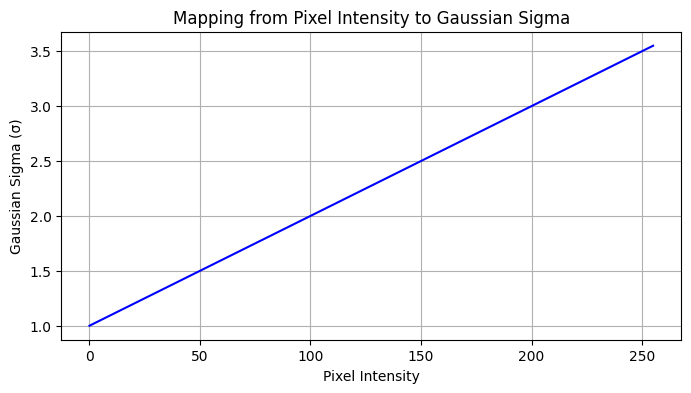

In [52]:
intensities = np.linspace(0, 255, 256)
sigmas = [linear_sigma_from_intensity(i) for i in intensities]

plt.figure(figsize=(8, 4))
plt.plot(intensities, sigmas, color='blue')
plt.xlabel("Pixel Intensity")
plt.ylabel("Gaussian Sigma (σ)")
plt.title("Mapping from Pixel Intensity to Gaussian Sigma")
plt.grid(True)
plt.show()


In [53]:
def sigmoid_sigma_from_intensity(I, sigma_min=0.5, sigma_max=5.0, k=0.05, I0=128):
    """
    Compute the Gaussian sigma value based on pixel intensity using a sigmoid mapping.
    
    Parameters:
        I (float or numpy.ndarray): Pixel intensity value(s), typically in the range 0-255.
        sigma_min (float): The minimum sigma value (for dark pixels).
        sigma_max (float): The maximum sigma value (for bright pixels).
        k (float): Controls the steepness of the transition.
        I0 (float): The pixel intensity at which the transition is most rapid (inflection point).
        
    Returns:
        float or numpy.ndarray: The computed sigma value(s) corresponding to the input intensity.
    """
    sigma = sigma_min + (sigma_max - sigma_min) / (1 + np.exp(-k * (I - I0)))
    return sigma

For intensity 200, the computed sigma is 4.88


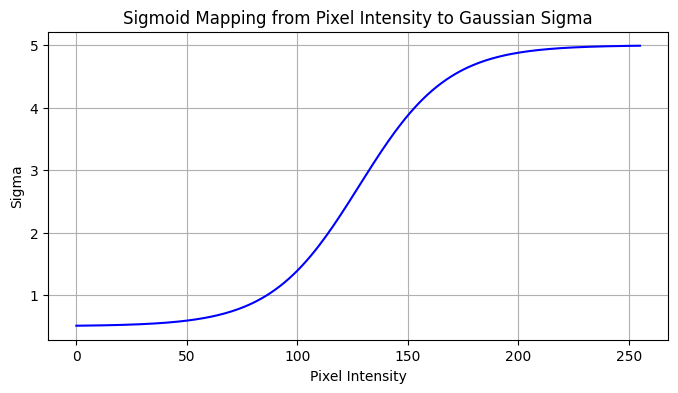

In [54]:
intensity_example = 200
sigma_example = sigmoid_sigma_from_intensity(intensity_example)
print(f"For intensity {intensity_example}, the computed sigma is {sigma_example:.2f}")

# To test on an array of intensity values:
intensities = np.linspace(0, 255, 256)
sigmas = sigmoid_sigma_from_intensity(intensities)

plt.figure(figsize=(8, 4))
plt.plot(intensities, sigmas, color='blue')
plt.xlabel("Pixel Intensity")
plt.ylabel("Sigma")
plt.title("Sigmoid Mapping from Pixel Intensity to Gaussian Sigma")
plt.grid(True)
plt.show()

In [55]:
def kernel_size_from_sigma(sigma):
    """
    Compute the Gaussian kernel size from sigma.
    Typically, size = 2 * ceil(3 * sigma) + 1 to cover ~99% of the Gaussian.
    """
    size = int(2 * np.ceil(3 * sigma) + 1)
    return size

# Example: Print sigma and kernel size for some sample intensities.
sample_intensities = [50, 100, 150, 200, 250]
print("Intensity | Linear Sigma | Linear Kernel Size | Sigmoid Sigma | Sigmoid Kernel Size")
for intensity in sample_intensities:
    sigma_linear = linear_sigma_from_intensity(intensity)
    kernel_linear = kernel_size_from_sigma(sigma_linear)
    
    sigma_sigmoid = sigmoid_sigma_from_intensity(intensity)
    kernel_sigmoid = kernel_size_from_sigma(sigma_sigmoid)
    
    print(f"{intensity:9d} | {sigma_linear:12.2f} | {kernel_linear:18d} | {sigma_sigmoid:13.2f} | {kernel_sigmoid:18d}")



Intensity | Linear Sigma | Linear Kernel Size | Sigmoid Sigma | Sigmoid Kernel Size
       50 |         1.50 |                 11 |          0.59 |                  5
      100 |         2.00 |                 13 |          1.39 |                 11
      150 |         2.50 |                 17 |          3.88 |                 25
      200 |         3.00 |                 19 |          4.88 |                 31
      250 |         3.50 |                 23 |          4.99 |                 31


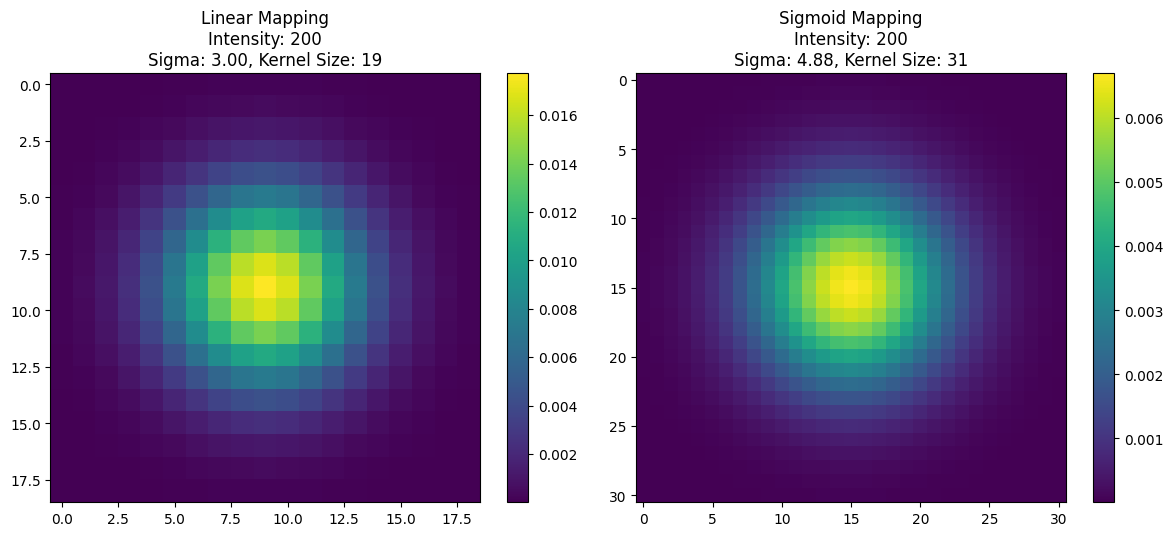

In [56]:
def get_gaussian_kernel_linear(intensity, sigma_min=1.0, beta=0.01):
    """
    Generate a 2D Gaussian kernel for a given pixel intensity using a linear mapping.
    
    Parameters:
      intensity (float): Pixel intensity (0-255).
      sigma_min (float): Minimum sigma for dark pixels.
      beta (float): Linear scaling factor that increases sigma with intensity.
      
    Returns:
      kernel_2d (np.ndarray): The 2D Gaussian kernel.
      sigma (float): Computed sigma value.
      ksize (int): Kernel size.
    """
    sigma = linear_sigma_from_intensity(intensity, sigma_min, beta)
    ksize = kernel_size_from_sigma(sigma)
    kernel_1d = cv2.getGaussianKernel(ksize, sigma)
    kernel_2d = kernel_1d * kernel_1d.T
    return kernel_2d, sigma, ksize

def get_gaussian_kernel_sigmoid(intensity, sigma_min=0.5, sigma_max=5.0, k=0.05, I0=128):
    """
    Generate a 2D Gaussian kernel for a given pixel intensity using a sigmoid mapping.
    
    Parameters:
      intensity (float): Pixel intensity (0-255).
      sigma_min (float): Minimum sigma for dark pixels.
      sigma_max (float): Maximum sigma for bright pixels.
      k (float): Controls the steepness of the sigmoid transition.
      I0 (float): The intensity at which the transition is most rapid.
      
    Returns:
      kernel_2d (np.ndarray): The 2D Gaussian kernel.
      sigma (float): Computed sigma value.
      ksize (int): Kernel size.
    """
    sigma = sigmoid_sigma_from_intensity(intensity, sigma_min, sigma_max, k, I0)
    ksize = kernel_size_from_sigma(sigma)
    kernel_1d = cv2.getGaussianKernel(ksize, sigma)
    kernel_2d = kernel_1d * kernel_1d.T
    return kernel_2d, sigma, ksize

# Set a sample intensity to analyze (e.g., 200)
intensity_example = 200

# Generate kernels using both mappings
kernel_linear, sigma_linear, ksize_linear = get_gaussian_kernel_linear(intensity_example)
kernel_sigmoid, sigma_sigmoid, ksize_sigmoid = get_gaussian_kernel_sigmoid(intensity_example)

# Plot the two kernels side by side for comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(kernel_linear, cmap='viridis')
plt.colorbar()
plt.title(f"Linear Mapping\nIntensity: {intensity_example}\nSigma: {sigma_linear:.2f}, Kernel Size: {ksize_linear}")

plt.subplot(1, 2, 2)
plt.imshow(kernel_sigmoid, cmap='viridis')
plt.colorbar()
plt.title(f"Sigmoid Mapping\nIntensity: {intensity_example}\nSigma: {sigma_sigmoid:.2f}, Kernel Size: {ksize_sigmoid}")

plt.tight_layout()
plt.show()